In [0]:
# Execute this cell to install OpenMM in the Colab environment
!pip install -q openmm
# We also need to get a few files that the cookbook depends on
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/1AKI-processed.cif'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/getting_started_3.png'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/constant_potential_3.png'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/pmf.png'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/deca-alanine.png'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/constant_potential_positions.txt'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/initial_config.png'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/getting_started_2.png'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/equilibrated_config.png'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/deca-ala.pdb'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/constant_potential_1.png'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/input.prmtop'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/getting_started_4.png'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/constant_potential_4.png'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/getting_started_1.png'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/sine.svg'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/constant_potential_2.png'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/input.inpcrd'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/villin.pdb'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/umbrella_sampling.svg'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/cg_ff.xml'
!wget -q 'https://raw.githubusercontent.com/openmm/openmm-cookbook/main/notebooks/tutorials/hist.png'

# Nuclear Quantum Effects With RPMD and adQTB

Nuclear quantum effects (NQEs) play an important role in many molecular systems.  This is especially true for low temperature simulations, but in some cases they can even be significant at room temperature.  For example, they are important in systems like water where hydrogen bonding plays a major role (https://doi.org/10.1021/acs.chemrev.5b00674).

OpenMM has two methods for simulating nuclear quantum effects: Ring Polymer Molecular Dynamics (RPMD) and Adaptive Quantum Thermal Bath (adQTB).  This tutorial shows how to use both of them and compares the results.

## Example: Parahydrogen

Molecular hydrogen ($H_2$) can exist in two nuclear spin states.  In orthohydrogen the nuclear spins are parallel to each other, and in parahydrogen they are antiparallel.  Parahydrogen is the more common state at low temperature, while orthohydrogen is the more common state at high temperature.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/41/Spinisomers_of_molecular_hydrogen.png" style="height:200px;margin-left:auto;margin-right:auto"/>

For this tutorial, we will simulate a box of parahydrogen molecules at 25 Kelvin.  First let's import the libraries we will be using.

In [1]:
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import matplotlib.pyplot as plot

Now we build a system to represent the box of molecules.  Each molecule is represented by a single particle.  They interact with each other through an empirical pairwise potential (https://doi.org/10.1063/1.437103).

In [2]:
particles = 32
box_size = 1.1896
temperature = 25*kelvin
system = System()
system.setDefaultPeriodicBoxVectors(Vec3(box_size, 0, 0), Vec3(0, box_size, 0), Vec3(0, 0, box_size))
force = CustomNonbondedForce(
    """2625.49963*(exp(1.713-1.5671*p-0.00993*p*p) -
                   (12.14/p^6+215.2/p^8-143.1/p^9+4813.9/p^10)*(step(rc-p)*exp(-(rc/p-1)^2)+1-step(rc-p)));
                   p=r/0.05291772108; rc=8.32""")
force.setNonbondedMethod(CustomNonbondedForce.CutoffPeriodic)
force.setCutoffDistance(box_size/2)
system.addForce(force)
for i in range(particles):
    system.addParticle(2.0*amu)
    force.addParticle()
positions = np.random.rand(particles, 3)*box_size

We are going to simulate this box of parahydrogen and record the pairwise radial distribution function (RDF).  The following function runs the simulation and computes the RDF.

In [3]:
def compute_rdf(context):
    bins = 100
    iterations = 2000
    counts = [0]*bins
    for _ in range(iterations):
        # Run a few steps of dynamics.

        context.getIntegrator().step(20)

        # Count the number of distances in each bin.

        pos = context.getState(positions=True).getPositions().value_in_unit(nanometer)
        for i in range(particles):
            for j in range(i):
                delta = pos[i]-pos[j]
                delta -= np.round(delta/box_size)*box_size # Apply periodic boundary conditions
                dist = norm(delta)
                counts[int(bins*dist/box_size)] += 1

    # Convert the histogram of distances to the RDF.

    scale = (box_size*box_size*box_size)/(iterations*0.5*particles*particles);
    rdf = []
    for i in range(bins//2):
        r1 = i*box_size/bins
        r2 = (i+1)*box_size/bins
        volume = (4.0/3.0)*np.pi*(r2*r2*r2-r1*r1*r1)
        rdf.append(scale*counts[i]/volume)
    return rdf

Before we look at NQEs, first let's run a simulation with a standard Langevin integrator.  This gives us the classical distribution.

In [4]:
integrator = LangevinIntegrator(temperature, 1.0/picosecond, 1*femtosecond)
context = Context(system, integrator)
context.setPositions(positions)
LocalEnergyMinimizer.minimize(context)
context.setVelocitiesToTemperature(temperature)
integrator.step(1000) # Equilibrate before collecting data
classical_rdf = compute_rdf(context)

Here is a graph of the RDF, so we can see what it looks like.

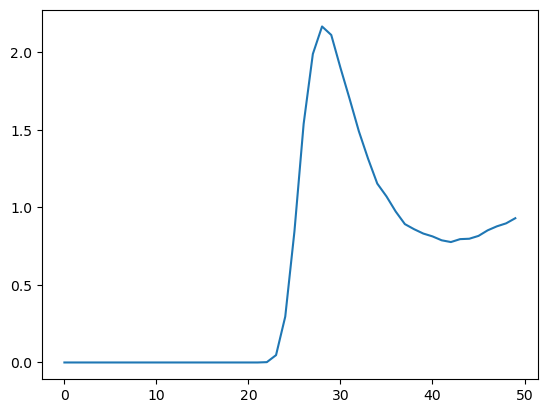

In [5]:
plot.plot(classical_rdf)
plot.show()

## Ring Polymer Molecular Dynamics

RPMD is based on the path integral formulation of quantum mechanics, which says that a quantum mechanical trajectory is equivalent to summing over all possible classical trajectories.  As a faster approximation, we randomly sample from the set of possible trajectories by simulating many copies of the system at once.  As the number of copies goes to infinity, the RPMD result converges to the exact quantum result.

Running a simulation with RPMD is very similar to running an ordinary simulation, except that we must tell it how many copies to simulate.  For parahydrogen we can get a reasonably well converged result with 12 copies.  Other systems often require more, which can make them very expensive to simulate.

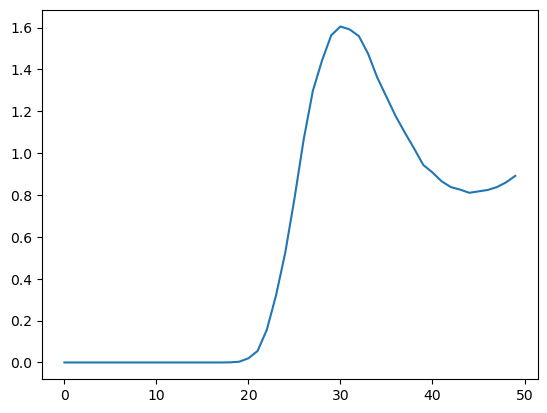

In [6]:
copies = 12
integrator = RPMDIntegrator(copies, temperature, 1.0/picosecond, 1*femtosecond)
context = Context(system, integrator)
context.setPositions(positions)
LocalEnergyMinimizer.minimize(context)
context.setVelocitiesToTemperature(temperature)
integrator.step(1000) # Equilibrate before collecting data
rpmd_rdf = compute_rdf(context)
plot.plot(rpmd_rdf)
plot.show()

We can see at a glance that the distribution is significantly different from the classical one with a lower, broader peak.  The simulation takes much longer to run, since it must repeat all the calculations for every copy in each time step.

## Adaptive Quantum Thermal Bath

adQTB is a much faster alternative based on a different approximation (https://doi.org/10.1021/acs.jctc.8b01164).  It uses a colored (i.e. frequency dependent) noise thermostat whose energy at each frequency matches the average energy of a quantum harmonic oscillator:

$\theta(\omega, T) = \hbar \omega \left( \frac{1}{2} + \frac{1}{e^{\hbar \omega / k_B T} - 1} \right)$

For harmonic degrees of freedom this produces the correct energy distribution.  For non-harmonic ones it is an approximation, but still often a very good one.

A problem that can happen with this approach is zero point energy leakage.  The thermostat drives the system toward the desired quantum energy distribution, but the classical dynamics of the system causes it to continuously relax toward the
classical distribution.  The result is a distribution in between the quantum and classical ones with too much energy in the low frequency modes and too little energy in the high frequency modes.

The adaptive version of the algorithm compensates for this by monitoring the energy distribution in the system and continuously adjusting the amount of noise at each frequency to bring the system closer to the intended distribution.  In practice this works as follows.

1. Divide the trajectory into short segments, typically on the order of 1000 time steps.
2. During each segment, monitor the distribution of energy across modes.
3. At the end of each segment, adjust the amount of noise at each frequency accordingly.

This procedure tends to be very effective, but it does make adQTB slightly more complicated to use.  Let's start by creating the integrator.

In [7]:
integrator = QTBIntegrator(temperature, 20.0/picosecond, 1*femtosecond)

Notice that we are using a larger friction coefficient than we did for the other integrators.  This is usually required for adQTB.  If the friction is too low, it may be impossible to fully compensate for zero point energy leakage.  Even reducing the noise magnitude to zero would leave too much energy in some modes.  This can slow down motions and cause sampling to take longer, but it still ends up being much faster than RPMD.

Next we tell it how long the individual segments of the trajectory should be.  In this case we set them to 0.5 ps.

In [8]:
integrator.setSegmentLength(0.5*picosecond)

By default, the adaptation algorithm keeps track of a different noise spectrum for every particle in the system and adapts each one separately.  When multiple particles are expected to behave identically, you should tell it to use the same spectrum for all of them.  This allows it to average the data from them, making the algorithm more stable and allowing adaptation to happen more quickly.

To do this, we call `setParticleType()` to give every particle a type.  If two particles have the same type, they share the same noise spectrum.  Since every particle in our system is identical, we give them all the same type.

In [9]:
for i in range(particles):
    integrator.setParticleType(i, 0)

Finally we must tell it how quickly to adjust the noise spectrum.  We do this by setting the adaptation rate.  Larger values lead to faster adaptation, but too large a value can lead to noisy results or even prevent it from converging.  There is no easy rule for picking the adaptation rate.  Usually you need to select it through trial and error.

In [10]:
integrator.setDefaultAdaptationRate(0.5)

It also is possible to set different adaptation rates for different particle types by calling `setTypeAdaptationRate()`.  For example, if there are many more particles of one type than other, you might want a larger adaptation rate for the type with more particles.  In most cases, though, it is fine to use the same adaptation rate for all types.  Since our system only has a single particle type, this is not relevant to it anyway.

Now that our integrator is set up, let's create the Context.  This part is exactly the same as for the other integrators.

In [11]:
context = Context(system, integrator)
context.setPositions(positions)
LocalEnergyMinimizer.minimize(context)
context.setVelocitiesToTemperature(temperature)

Now we need to equilibrate the system.  In the earlier cases we just ran a short simulation to let the particle positions and velocities relax.  For adQTB, equilibration serves another important function: it gives the adaptation algorithm time to select the noise spectra.  This may require a much longer equilibration, and you should monitor the progress of it to make sure the result is truly converged before you start collecting data.

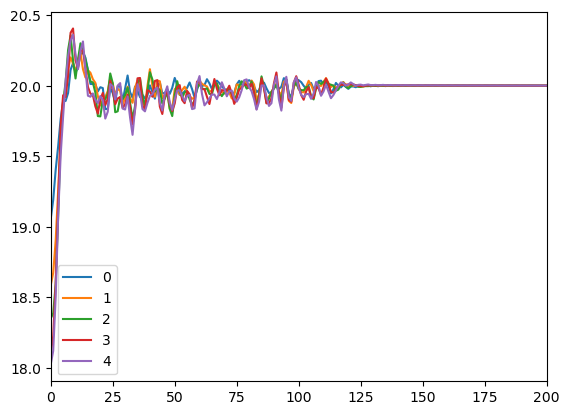

In [12]:
for i in range(5):
    integrator.step(20000)
    plot.plot(integrator.getAdaptedFriction(0), label=f'{i}')
plot.xlim([0, 200])
plot.legend()
plot.show()

We can see the spectrum is well converged, so now we compute the RDF as before.

In [13]:
qtb_rdf = compute_rdf(context)

Now that we have all three versions of the RDF, let's compare them.

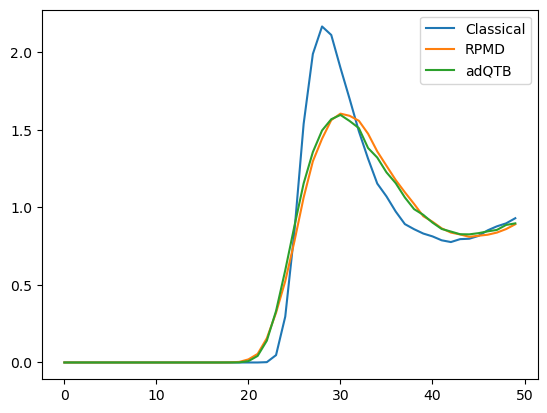

In [14]:
plot.plot(classical_rdf, label="Classical")
plot.plot(rpmd_rdf, label="RPMD")
plot.plot(qtb_rdf, label="adQTB")
plot.legend()
plot.show()

The results from RPMD and adQTB are very similar, while the classical simulation produced a quite different distribution.  That shows the importance of NQEs in this system.

## When Should You Include Nuclear Quantum Effects?

You might be tempted to add nuclear quantum effects to all your simulations, especially given the relatively low cost of adQTB, but that would not be correct.  Most force fields are parameterized at least partly based on experimental data.  That means they already implicitly take NQEs into account.  They are designed to match experiment *without* explicitly adding NQEs.

On the other hand, quantum chemistry methods like Density Functional Theory treat nuclei classically, using quantum mechanics only for the electrons.  QM/MM simulations can therefore benefit from adding explicit NQEs.  The same is true of force fields and machine learning potentials that are parameterized solely from quantum chemistry data.  The potential function reflects a purely classical model of the nuclei.  Using RPMD or adQTB to add quantum effects increases the realism of the model.